#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

In [1]:
%load_ext zipline

## Support and Resistance Strategy 

This note book runs the strategy in Zipline backtest engine to make sure the performance is inline with that from the stand-alone strategy function in the Support and Resistance Strategy CPCV notebook. 

It also implements a version of the strategy where Hurst exponents are utilized to help refine trading signals. The performance with and without Hurst exponent are shown below. The benefit of adding this element to the strategy can be confirmed through the help of Combinatorial Purged Cross Validation. 

Note that the code for the version with Hurst exponents are at the end of this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import OrderedDict
from datetime import datetime, timedelta
import pytz

import zipline
from zipline.api import *
from zipline.utils.always_open import AlwaysOpenCalendar

import pyfolio as pf
import empyrical

In [33]:
data = OrderedDict()
data['BTC'] = pd.read_csv("/Users/nguyentuanhoa/Downloads/Crypto/zipline/data/bitmex_april5_july20_2020.csv",index_col=0,parse_dates=True)

# Zipline only allows trading of whole number of any particular security.
# However, BTC is traded on exchanges in tiny fractions of a single Bitcoin. 
# To allow for realistic backtesting with Zipline, we rescaled the price and volume of BTC
muliplier = 100
data['BTC'].loc[:,'open':'close'] /= muliplier
data['BTC'].volume *= muliplier

panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

In [23]:
def initialize(context):    
    set_benchmark(symbol('BTC'))
    context.security = symbol('BTC')
    
    context.take_profit = 0    # to help debug
    context.stopped_out = 0    # to help debug
    context.pos_ret = 0    # to help debug
    context.neg_ret = 0    # to help debug
    context.orders_cancelled = 0    # to help debug
    
    context.sr_window = 720
    context.mva_window = 70
    context.multiplier = 2
    
    context.pt = .04
    context.sl = -.015

def handle_data(context, data):
    
    price_history = data.history(
        context.security,
        fields='close',
        bar_count=context.sr_window,
        frequency='1m'
    )
    
    current_price = price_history[-1]
    
    fast_mva = price_history[-context.mva_window:].mean()
    PH = price_history.max()
    PL = price_history.min()
    PC = current_price
    C = (PH+PL+PC)/3
    R = context.multiplier*C-PL
    S = context.multiplier*C-PH
               
    pos_amount = context.portfolio.positions[context.security].amount
    btc_orders = get_open_orders(context.security)
    open_orders = False if len(btc_orders)==0 else btc_orders[0].status==0
    filled_price = context.portfolio.positions[context.security].cost_basis
   
    # put on short trades
    if not open_orders and not pos_amount and fast_mva < C:
        order_target_percent(context.security, -1, limit_price=fast_mva * .995)

    # put on long trades
    elif not open_orders and not pos_amount and fast_mva > C:
        order_target_percent(context.security, 1, limit_price=fast_mva * 1.005)

    # cancel unfilled trades after 15 minutes
    elif open_orders and btc_orders[0].status == 0 and get_datetime() - btc_orders[0].created >= timedelta(minutes=15):
        cancel_order(btc_orders[0])
        context.orders_cancelled += 1
        
    # take profits or stop loss
    elif not open_orders and pos_amount:
        if pos_amount<0:
            prct_changed = (filled_price-current_price)/filled_price
        else:
            prct_changed = (current_price-filled_price)/filled_price

        if fast_mva <= S and pos_amount<0:
            order_target_percent(context.security, 0)
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        elif fast_mva >= R and pos_amount>0:
            order_target_percent(context.security, 0)
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        elif prct_changed >= context.pt: 
            order_target_percent(context.security, 0)
            context.take_profit += 1
            context.pos_ret += 1
        elif prct_changed <= context.sl: 
            order_target_percent(context.security, 0)
            context.stopped_out += 1
            context.neg_ret += 1
        
    record(stopped_out = context.stopped_out, take_profits = context.take_profit, 
           cancelled = context.orders_cancelled, 
           pos_ret = context.pos_ret, neg_ret = context.neg_ret)


In [47]:
perf = zipline.run_algorithm(start=datetime(2020, 5, 31, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2020, 7, 19, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      handle_data=handle_data,
                      trading_calendar=AlwaysOpenCalendar(),
                      capital_base=20000,
                      data_frequency ='minute',
                      data=panel)

In [61]:
#perf.to_pickle('support_resistance_720_70_2_june1_july19_hurst')

In [49]:
perf2 = pd.read_pickle('support_resistance_720_70_2_june1_july19')

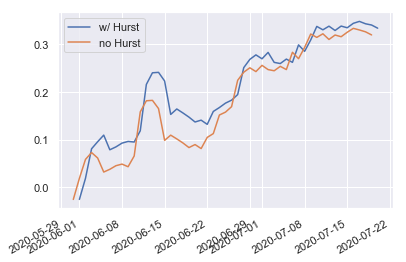

In [55]:
perf.algorithm_period_return.plot(label='w/ Hurst')
perf2.algorithm_period_return.plot(label='no Hurst')
plt.legend()

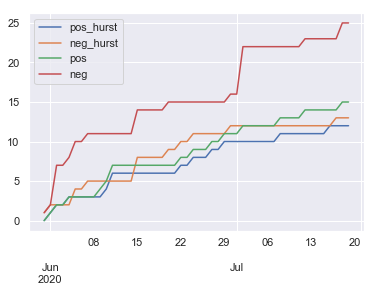

In [62]:
perf.pos_ret.plot(label='pos_hurst')
perf.neg_ret.plot(label='neg_hurst')
perf2.pos_ret.plot(label='pos')
perf2.neg_ret.plot(label='neg')
plt.legend()

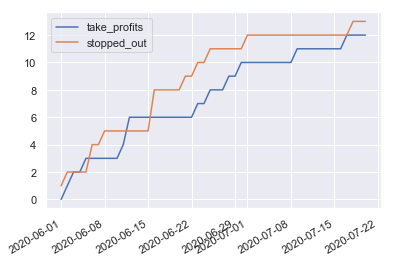

In [57]:
# for the version with Hurst

perf.take_profits.plot()
perf.stopped_out.plot()
plt.legend()

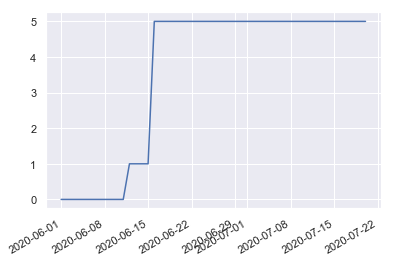

In [58]:
# for the version with Hurst
# number of canceled trades

perf.cancelled.plot()

In [59]:
returns, positions, transactions = \
    pf.utils.extract_rets_pos_txn_from_zipline(perf)

Start date,2020-05-31
End date,2020-07-19
Total months,2
,Backtest
Annual return,325.9%
Cumulative returns,33.3%
Annual volatility,35.0%
Sharpe ratio,4.33
Calmar ratio,37.18
Stability,0.85
Max drawdown,-8.8%


/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.76,2020-06-13,2020-06-21,2020-06-27,10
1,2.76,2020-06-04,2020-06-05,2020-06-10,5
2,1.82,2020-07-01,2020-07-03,2020-07-06,4
3,1.06,2020-07-16,2020-07-19,NaT,NaN
4,1.04,2020-07-06,2020-07-07,2020-07-08,3


Stress Events,mean,min,max
New Normal,0.60%,-5.72%,8.67%


Top 10 long positions of all time,max
sid,
BTC,100.95%


Top 10 short positions of all time,max
sid,
BTC,-102.00%


Top 10 positions of all time,max
sid,
BTC,102.00%


/anaconda3/envs/env_zipline/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


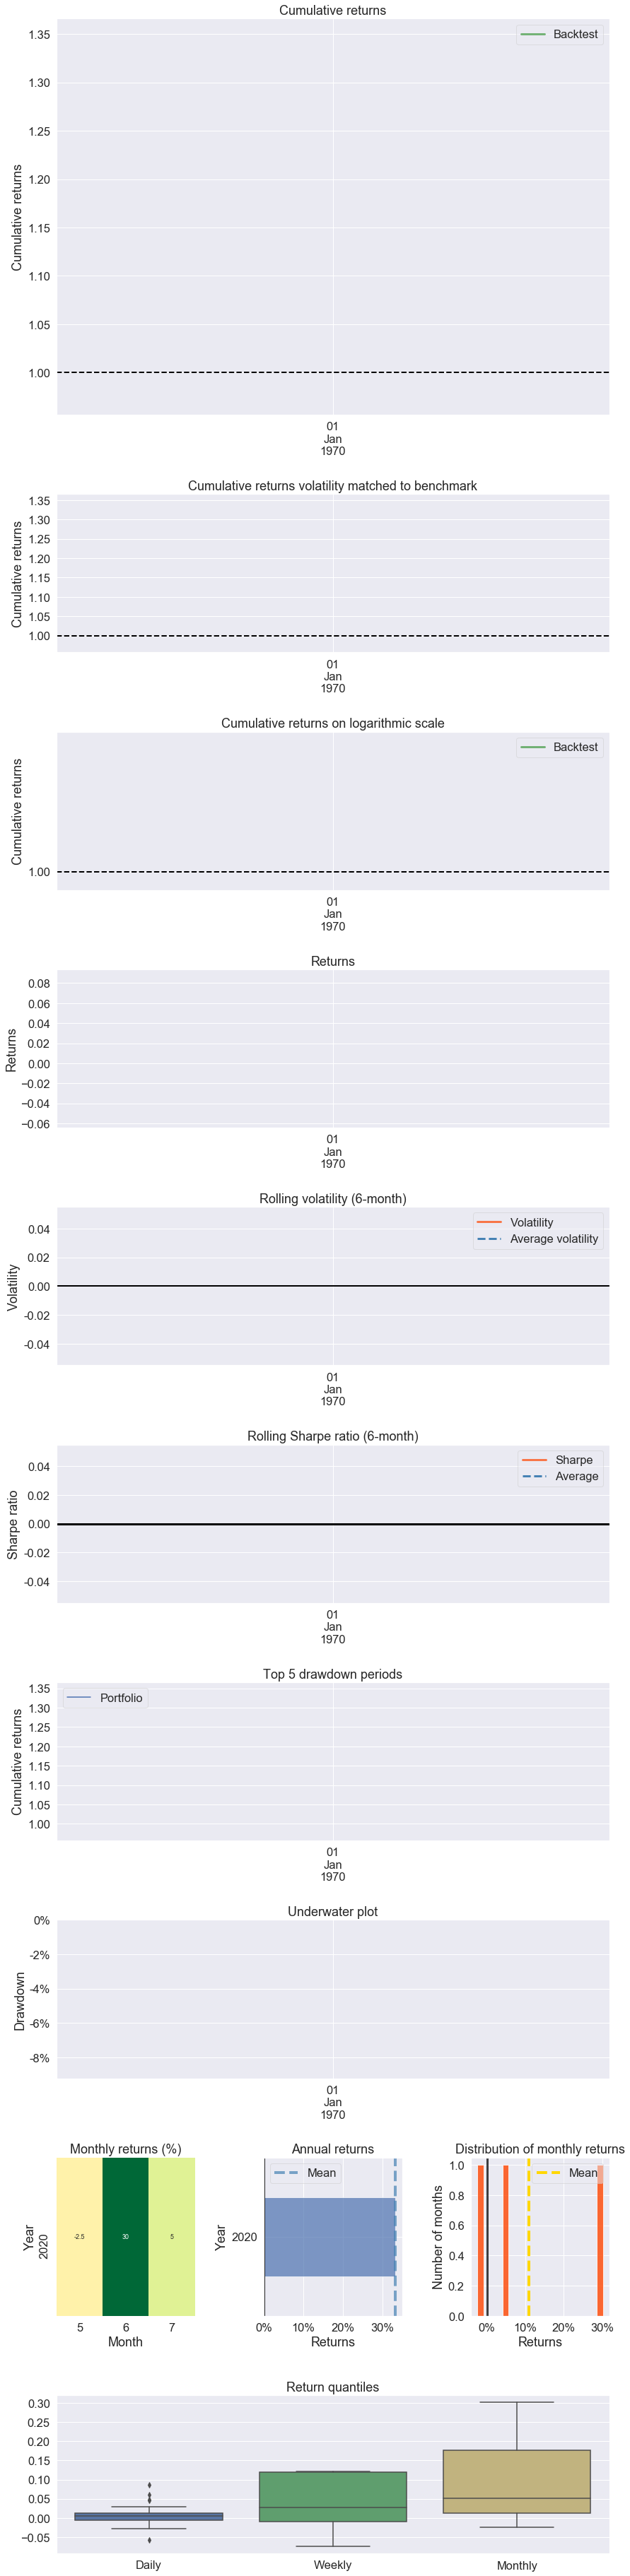

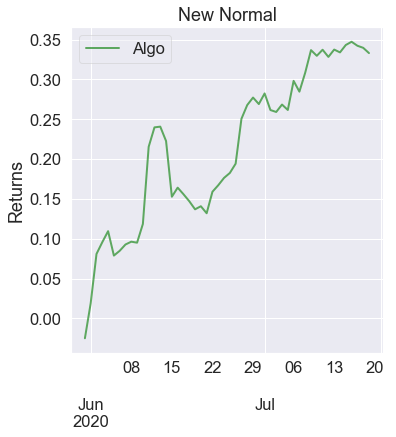

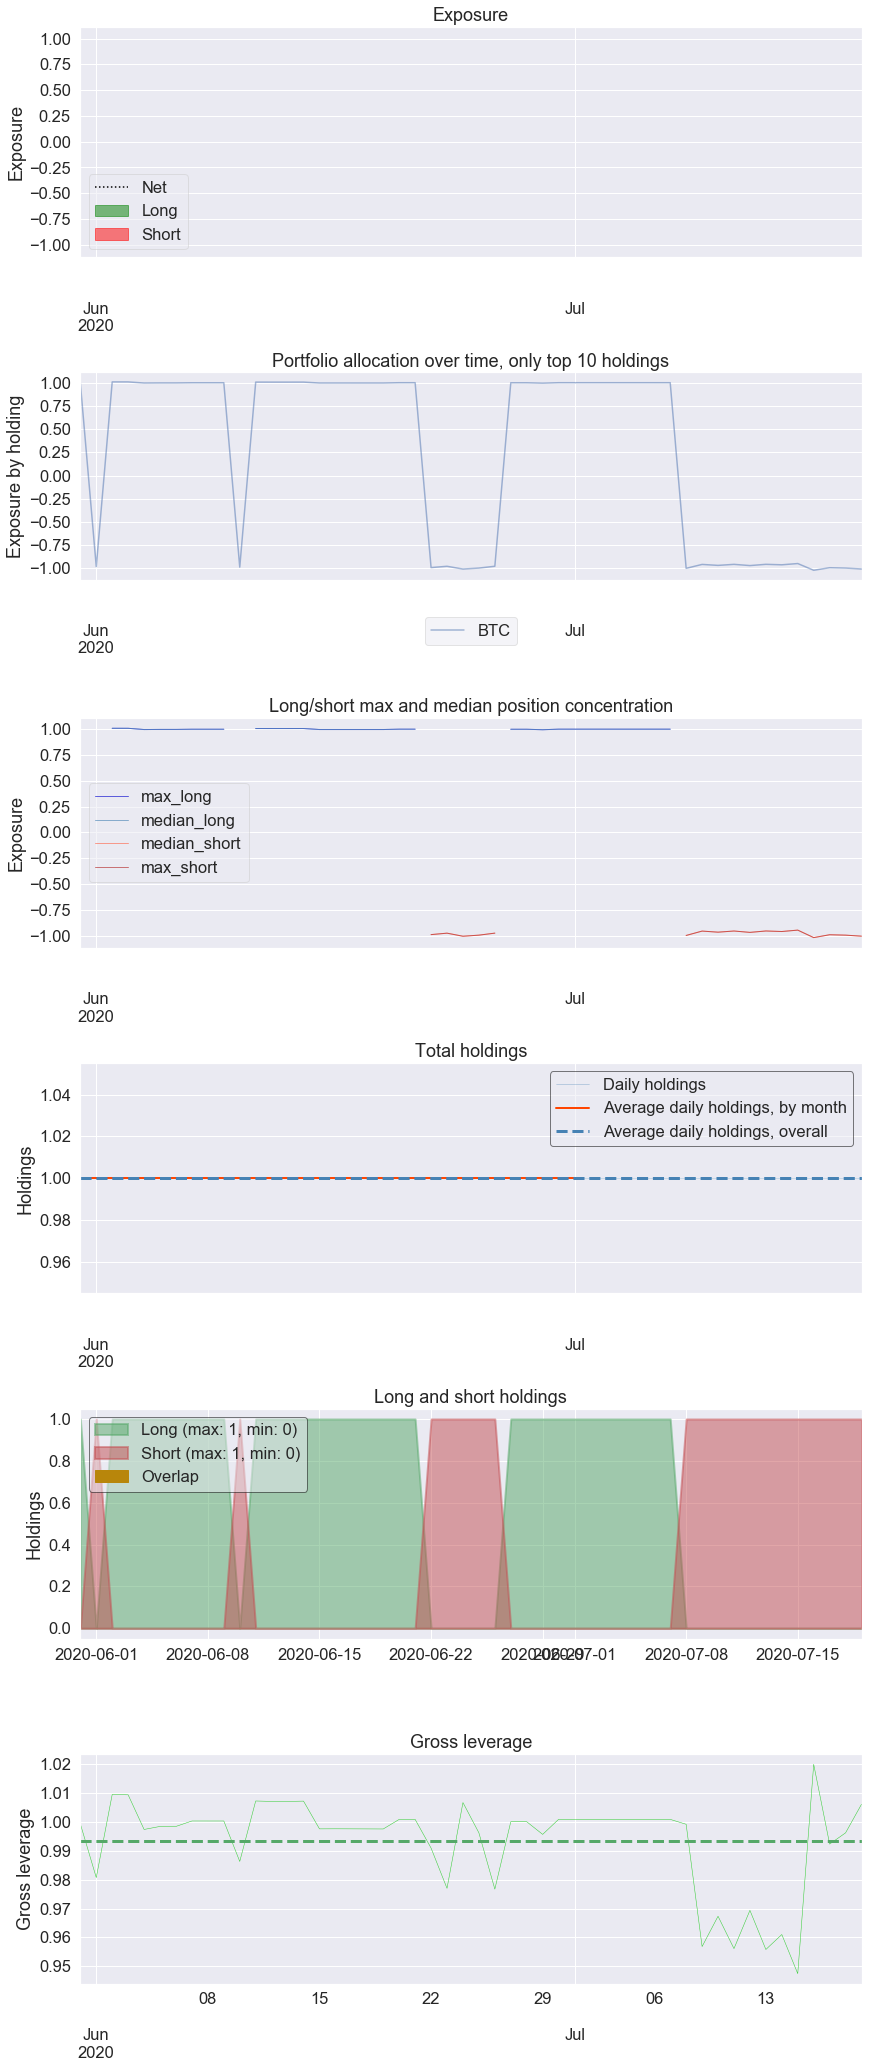

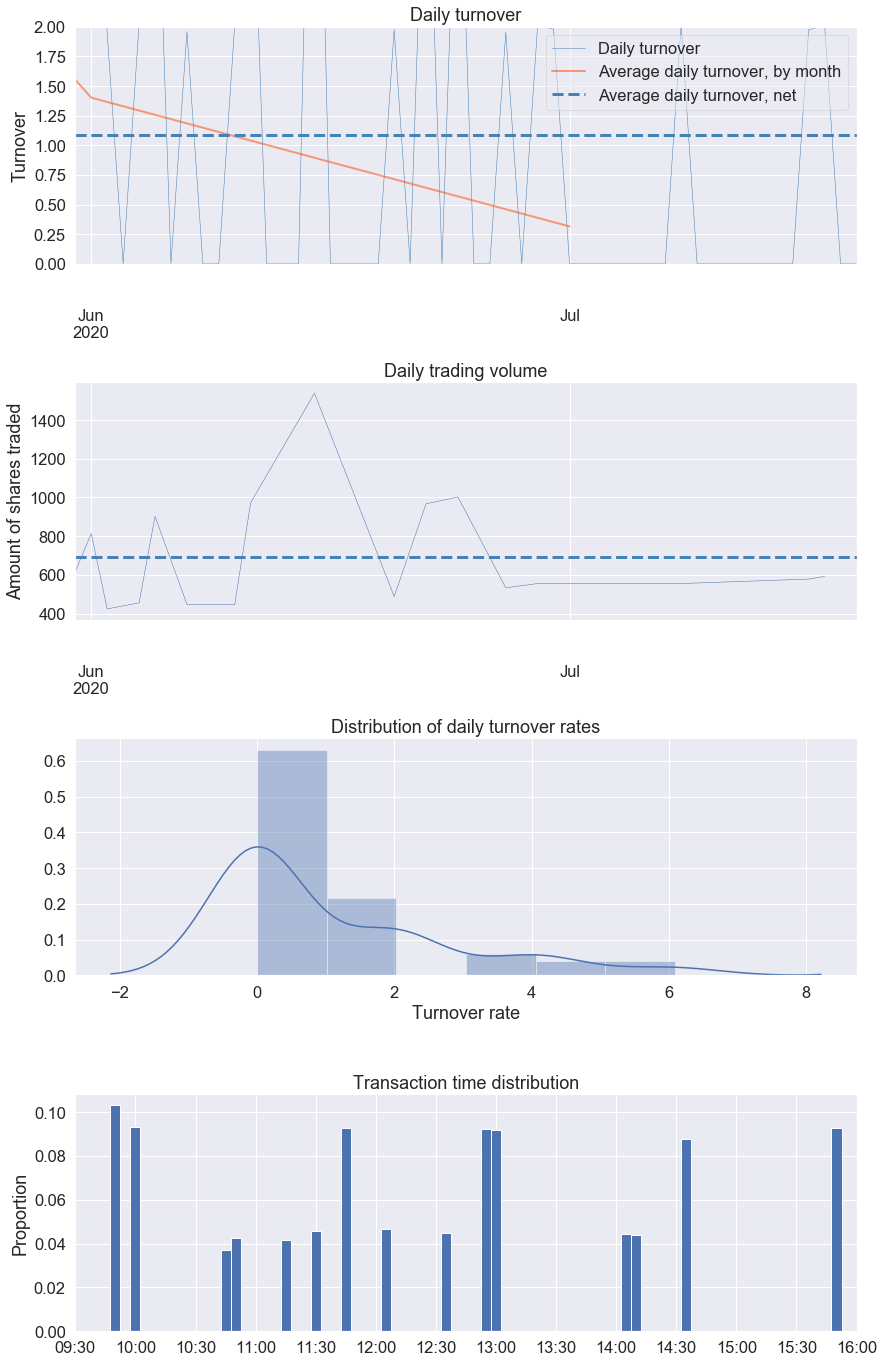

In [60]:
# for version with Hurst
# first few graphs did not get plotted

pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions)

Start date,2020-05-31
End date,2020-07-19
Total months,2
,Backtest
Annual return,303.6%
Cumulative returns,31.9%
Annual volatility,34.1%
Sharpe ratio,4.27
Calmar ratio,35.60
Stability,0.88
Max drawdown,-8.5%


/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.53,2020-06-13,2020-06-21,2020-06-27,10
1,3.80,2020-06-03,2020-06-05,2020-06-11,7
2,1.05,2020-07-06,2020-07-07,2020-07-08,3
3,1.03,2020-07-16,2020-07-19,NaT,NaN
4,0.90,2020-07-01,2020-07-03,2020-07-06,4


Stress Events,mean,min,max
New Normal,0.58%,-5.71%,8.66%


Top 10 long positions of all time,max
sid,
BTC,100.51%


Top 10 short positions of all time,max
sid,
BTC,-101.33%


Top 10 positions of all time,max
sid,
BTC,101.33%


/anaconda3/envs/env_zipline/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


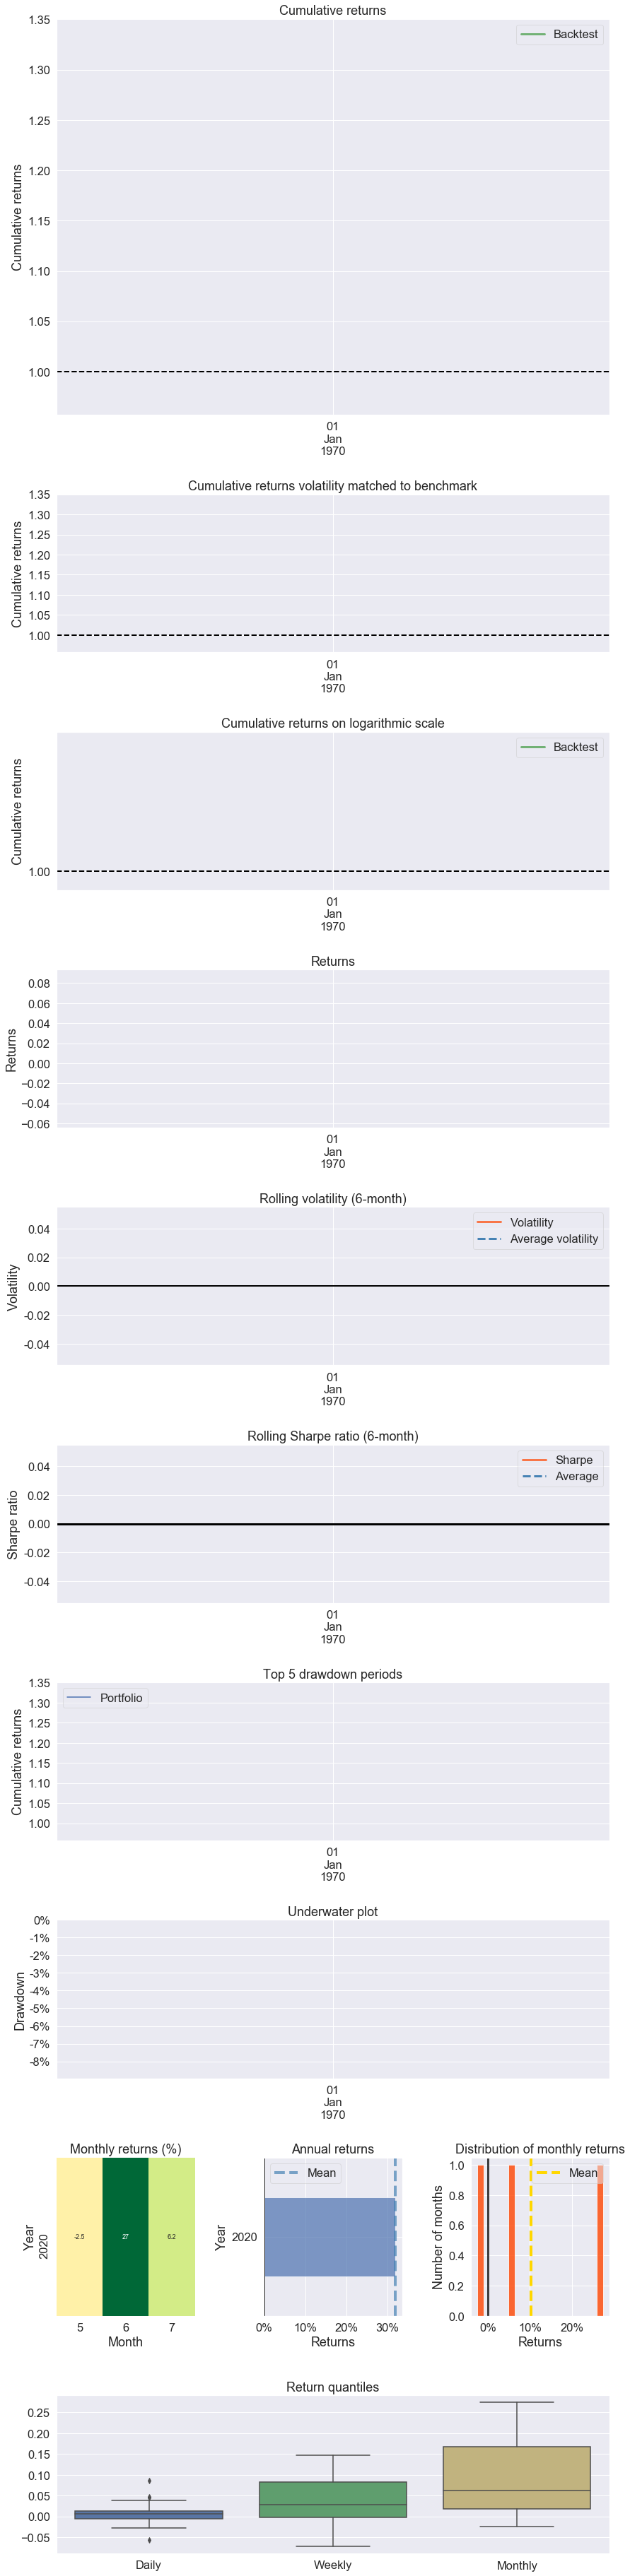

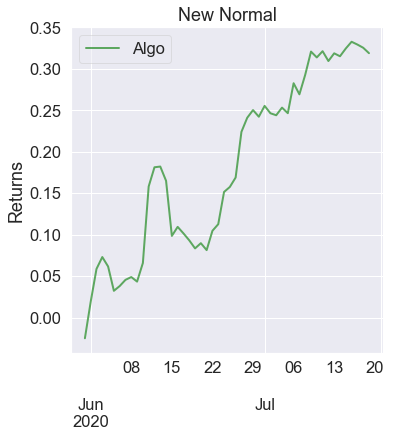

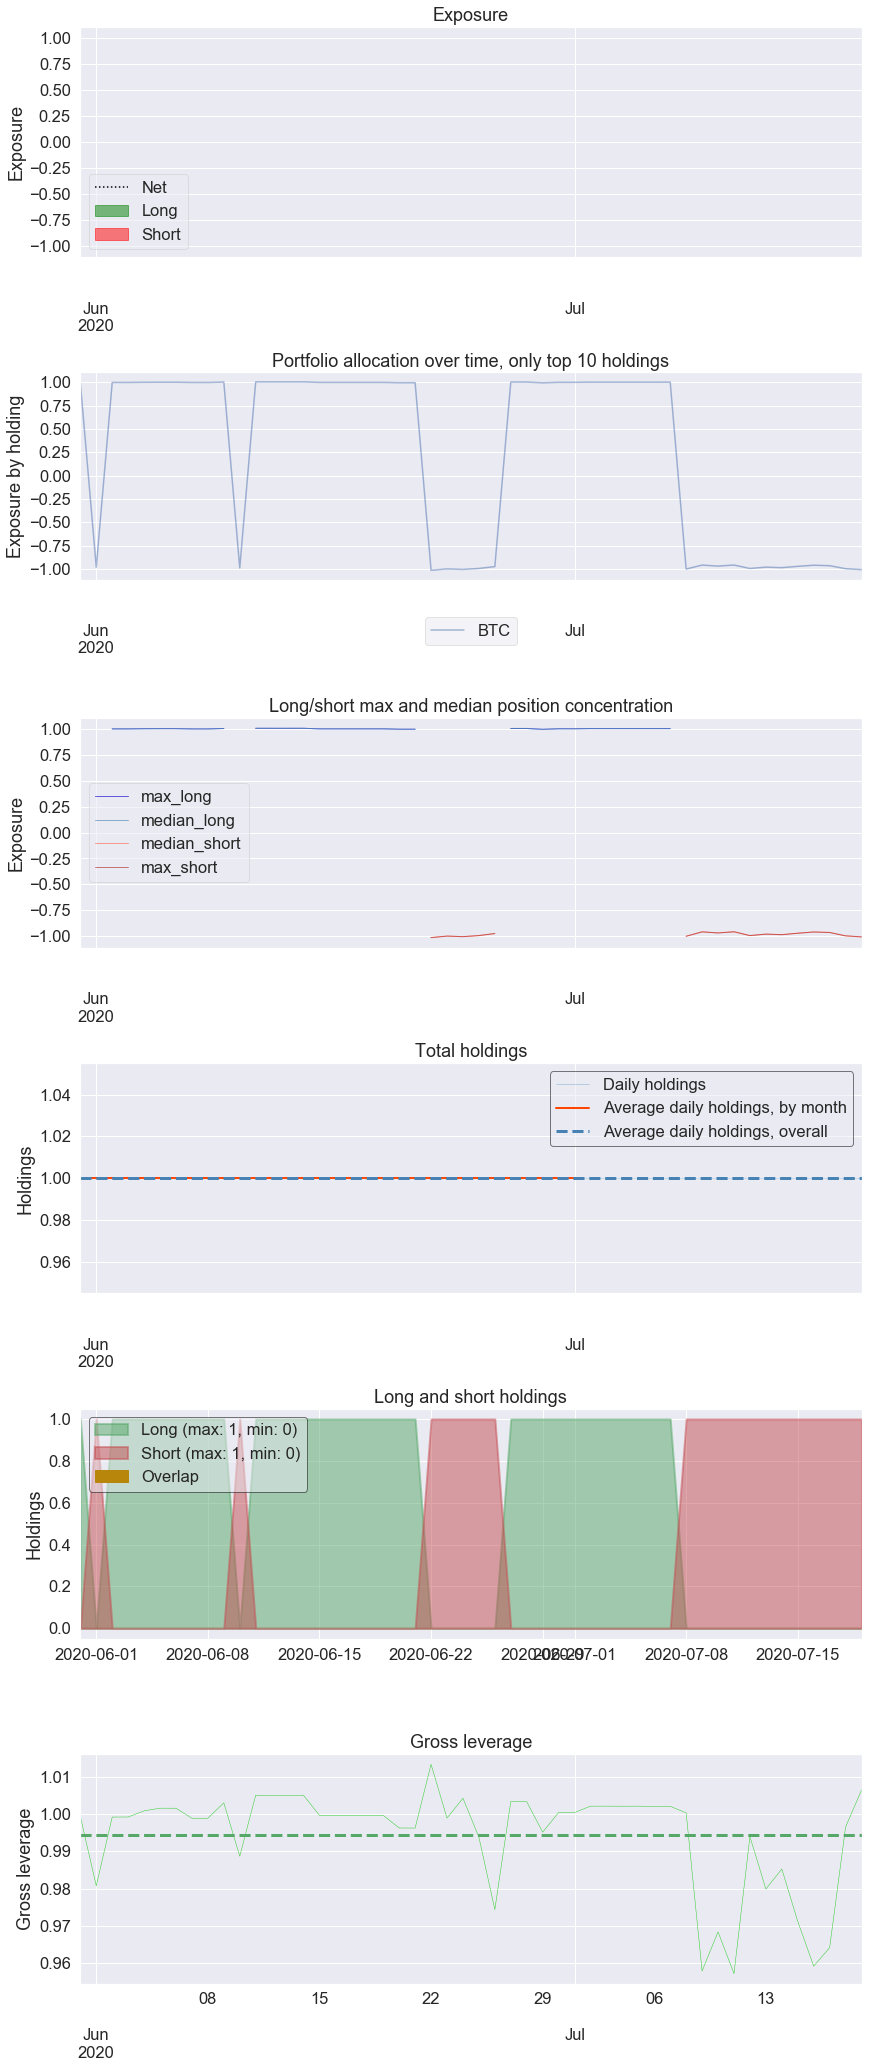

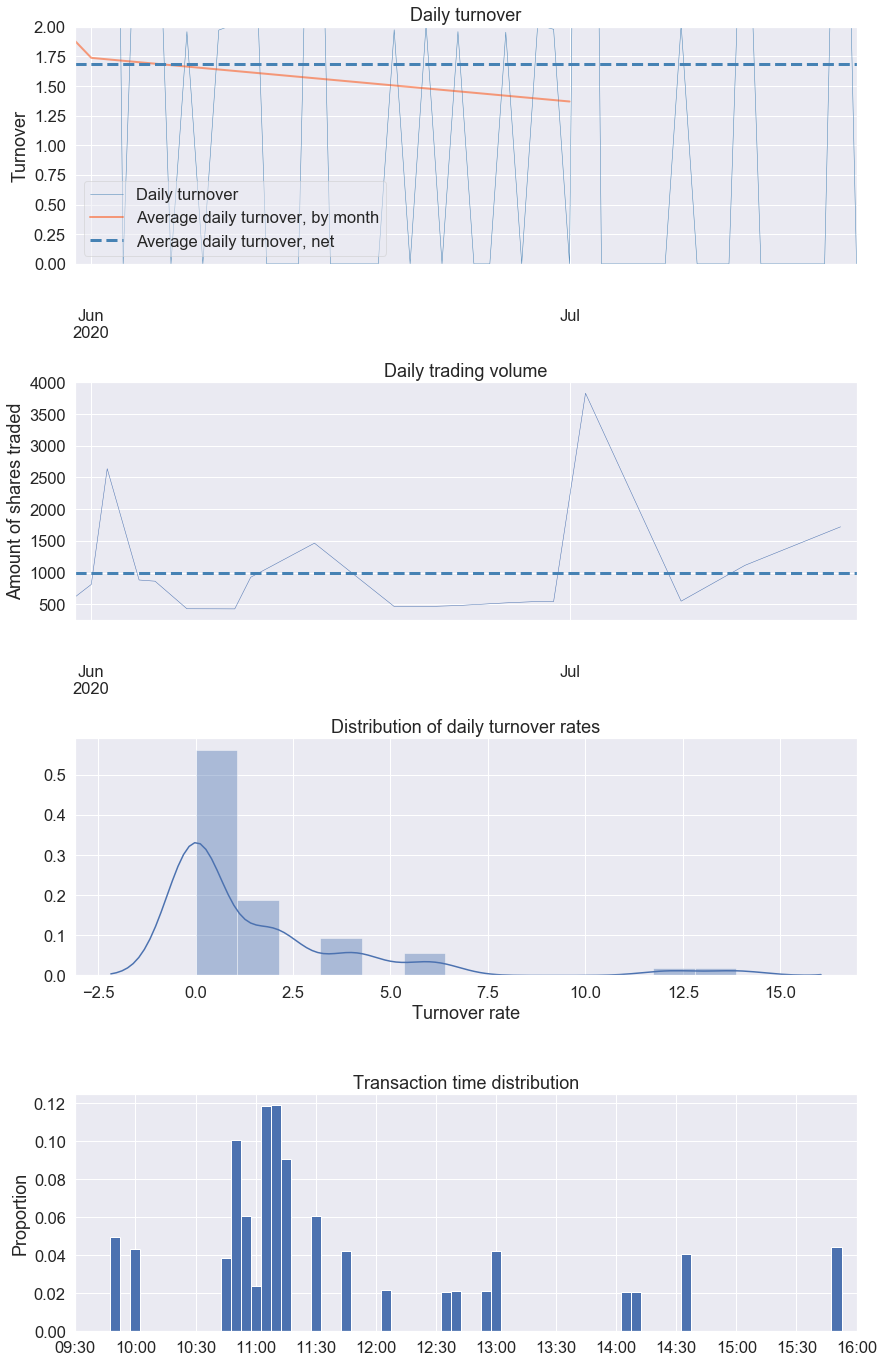

In [41]:
# for version without Hurst
# first few graphs did not get plotted

pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions)

In [43]:
from hurst import compute_Hc

In [46]:
def initialize(context):    
    set_benchmark(symbol('BTC'))
    context.security = symbol('BTC')
    
    context.take_profit = 0    # to help debug
    context.stopped_out = 0    # to help debug
    context.pos_ret = 0    # to help debug
    context.neg_ret = 0    # to help debug
    context.orders_cancelled = 0    # to help debug
    
    context.sr_window = 720
    context.mva_window = 70
    context.multiplier = 2
    
    context.pt = .04
    context.sl = -.015

def handle_data(context, data):
    
    price_history = data.history(
        context.security,
        fields='close',
        bar_count=context.sr_window,
        frequency='1m'
    )
    
    current_price = price_history[-1]
    
    fast_mva = price_history[-context.mva_window:].mean()
    PH = price_history.max()
    PL = price_history.min()
    PC = current_price
    C = (PH+PL+PC)/3
    R = context.multiplier*C-PL
    S = context.multiplier*C-PH
    hurst = compute_Hc(price_history[-120:], kind='price')[0]
               
    pos_amount = context.portfolio.positions[context.security].amount
    btc_orders = get_open_orders(context.security)
    open_orders = False if len(btc_orders)==0 else btc_orders[0].status==0
    filled_price = context.portfolio.positions[context.security].cost_basis
   
    # put on short trades
    if not open_orders and not pos_amount and fast_mva < C and hurst > .5:
        order_target_percent(context.security, -1, limit_price=fast_mva * .995)

    # put on long trades
    elif not open_orders and not pos_amount and fast_mva > C and hurst > .5:
        order_target_percent(context.security, 1, limit_price=fast_mva * 1.005)

    # cancel unfilled trades after 15 minutes
    elif open_orders and btc_orders[0].status == 0 and get_datetime() - btc_orders[0].created >= timedelta(minutes=15):
        cancel_order(btc_orders[0])
        context.orders_cancelled += 1
        
    # take profits or stop loss
    elif not open_orders and pos_amount:
        if pos_amount<0:
            prct_changed = (filled_price-current_price)/filled_price
        else:
            prct_changed = (current_price-filled_price)/filled_price

        if fast_mva <= S and pos_amount<0 and hurst < .35:
            order_target_percent(context.security, 0)
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        elif fast_mva >= R and pos_amount>0 and hurst < .35:
            order_target_percent(context.security, 0)
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        elif prct_changed >= context.pt: 
            order_target_percent(context.security, 0)
            context.take_profit += 1
            context.pos_ret += 1
        elif prct_changed <= context.sl: 
            order_target_percent(context.security, 0)
            context.stopped_out += 1
            context.neg_ret += 1
        
    record(stopped_out = context.stopped_out, take_profits = context.take_profit, 
           cancelled = context.orders_cancelled, 
           pos_ret = context.pos_ret, neg_ret = context.neg_ret)
